# **Klasifikasi Citra Biji Jagung**

## **Persiapan Data**

Mengimpor library

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

Menghubungkan G-Drive dengan Google Colab

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/CORN_SEEDS/data_17K.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: data/train/pure/dc354_silkcut_002_bottom_212.png  
  inflating: data/train/pure/dc354_discolored_000_bottom_062.png  
  inflating: data/train/pure/dc354_broken_004_bottom_228.png  
  inflating: data/train/pure/new_dc317_discolored_002_top_284.png  
  inflating: data/train/pure/new_dc317_discolored_002_bottom_036.png  
  inflating: data/train/pure/dc354_discolored_000_bottom_276.png  
  inflating: data/train/pure/new_dc354_broken_001_top_220.png  
  inflating: data/train/pure/new_dc317_silkcut_001_top_180.png  
  inflating: data/train/pure/new_dc317_discolored_001_bottom_142.png  
  inflating: data/train/pure/new_dc317_silkcut_000_top_216.png  
  inflating: data/train/pure/dc354_discolored_004_bottom_091.png  
  inflating: data/train/pure/new_dc354_broken_001_top_255.png  
  inflating: data/train/pure/dc354_discolored_006_top_137.png  
  inflating: data/train/pure/dc354_discolored_003_bottom_059.png  
  inflating: d

Menentukan Path File

In [ ]:
data_train = '/content/data/train'
os.listdir(data_train)

['broken', 'discolored', 'silkcut', 'pure']

In [ ]:
data_val = '/content/data/validation'
os.listdir(data_val)

['broken', 'discolored', 'silkcut', 'pure']

Jumlah Data Training

In [ ]:
train_broken = os.path.join(data_train, 'broken')
train_pure = os.path.join(data_train, 'pure')
train_discolored = os.path.join(data_train, 'discolored')
train_silkcut = os.path.join(data_train, 'silkcut')

print('total citra data train:', len(os.listdir(train_broken))+
                                 len(os.listdir(train_pure))+
                                 len(os.listdir(train_discolored))+
                                 len(os.listdir(train_silkcut)))

print('total citra data train pada kelas broken:', len(os.listdir(train_broken)))
print('total citra data train pada kelas pure:', len(os.listdir(train_pure)))
print('total citra data train pada kelas discolored:', len(os.listdir(train_discolored)))
print('total citra data train pada kelas silkcut:', len(os.listdir(train_silkcut)))

total citra data train: 14322
total citra data train pada kelas broken: 4554
total citra data train pada kelas pure: 5837
total citra data train pada kelas discolored: 2504
total citra data train pada kelas silkcut: 1427


Jumlah Data Validasi

In [ ]:
val_broken = os.path.join(data_val, 'broken')
val_pure = os.path.join(data_val, 'pure')
val_discolored = os.path.join(data_val, 'discolored')
val_silkcut = os.path.join(data_val, 'silkcut')

print('total citra data validasi:', len(os.listdir(val_broken))+
                                 len(os.listdir(val_pure))+
                                 len(os.listdir(val_discolored))+
                                 len(os.listdir(val_silkcut)))

print('total citra data validasi pada kelas broken:', len(os.listdir(val_broken)))
print('total citra data validasi pada kelas pure:', len(os.listdir(val_pure)))
print('total citra data validasi pada kelas discolored:', len(os.listdir(val_discolored)))
print('total citra data validasi pada kelas silkcut:', len(os.listdir(val_silkcut)))

total citra data validasi: 3479
total citra data validasi pada kelas broken: 1116
total citra data validasi pada kelas pure: 1428
total citra data validasi pada kelas discolored: 611
total citra data validasi pada kelas silkcut: 324


## **Pemrosesan Data**

In [ ]:
image_height = image_width = 224
batch_size = 512

Augmentasi Data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
            
                                   )
    
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        )

In [ ]:
train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123
)

validation_generator = validation_datagen.flow_from_directory(
    data_val,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 14322 images belonging to 4 classes.
Found 3479 images belonging to 4 classes.


Class Weight untuk menyamakan bobot per kelas

In [ ]:
from sklearn.utils import class_weight 
import numpy as np
from sklearn.utils import compute_class_weight

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.7862318840579711,
 1: 1.4299121405750799,
 2: 0.6134144252184341,
 3: 2.5091100210231256}

## **Perancangan CNN dengan ResNet152v2**

In [ ]:
from keras import regularizers
tf.keras.backend.clear_session()

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_height, image_width, 3))),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  
])
model.layers[0].trainable = False
model.summary()

234561536/234545216 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

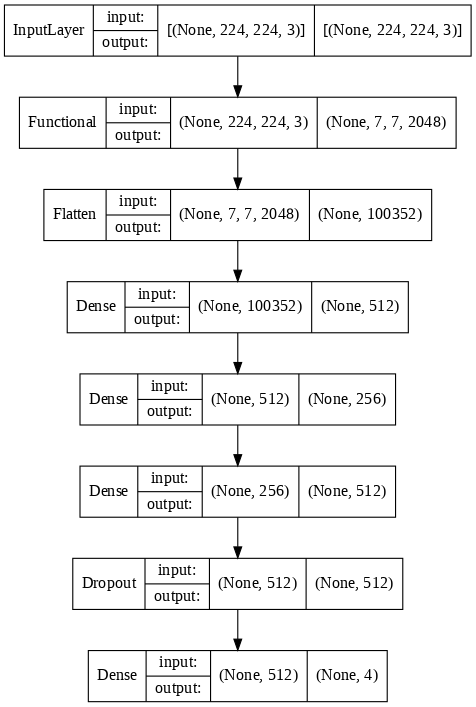

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

## **Training Model**

In [ ]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Penggunaan Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(train_generator, 
                    epochs=25,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, lr_scheduler],
                    shuffle = True)

Epoch 1/25
28/28 [==============================] - 263s 8s/step - loss: 6.0936 - accuracy: 0.4390 - val_loss: 2.4201 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - 216s 8s/step - loss: 2.2470 - accuracy: 0.6181 - val_loss: 1.9723 - val_accuracy: 0.6631 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - 224s 8s/step - loss: 1.8662 - accuracy: 0.6642 - val_loss: 1.7750 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 4/25
28/28 [==============================] - 214s 8s/step - loss: 1.6423 - accuracy: 0.6912 - val_loss: 1.6283 - val_accuracy: 0.6674 - lr: 0.0010
Epoch 5/25
28/28 [==============================] - 216s 8s/step - loss: 1.4767 - accuracy: 0.7201 - val_loss: 1.5712 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 6/25
28/28 [==============================] - 215s 8s/step - loss: 1.3648 - accuracy: 0.7298 - val_loss: 1.4265 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 7/25
28/28 [==============================] - 215s 8s/step - loss: 1.2

## **Testing Model**

In [ ]:
print(train_generator.class_indices)

{'broken': 0, 'discolored': 1, 'pure': 2, 'silkcut': 3}


In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['broken', 'discolored', 'pure', 'silkcut']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'broken'
  elif predict_label == 1:
      predict_class = 'discolored'
  elif predict_label == 3:
      predict_class = 'pure'
  else:
      predict_class = 'silkcut'

  return predict_class, df

Saving dc354_broken_000_bottom_000.png to dc354_broken_000_bottom_000 (3).png




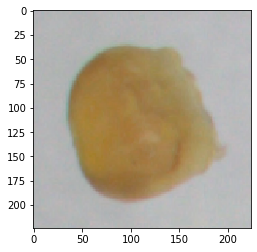


Gambar dikenali sebagai silkcut


        Kelas  Probability
0      broken     0.044792
1  discolored     0.000997
2        pure     0.954036
3     silkcut     0.000174




In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nGambar dikenali sebagai " + label)
print('\n')
print(df)
print('\n')

## **Evaluasi Model**

### **Visualisasi akurasi dan loss**

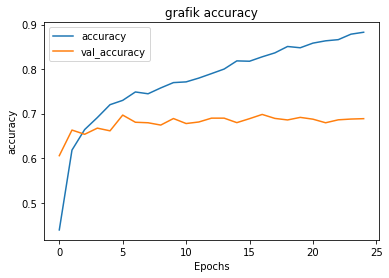

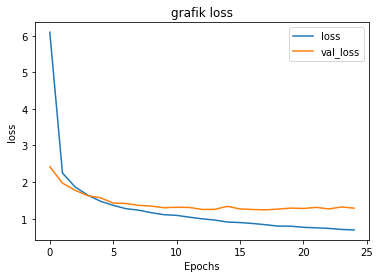

In [ ]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
grafik_plot(history, "accuracy")
grafik_plot(history, "loss")

In [ ]:
prediction= model.predict(validation_generator, steps=np.ceil(validation_generator.samples/validation_generator.batch_size), verbose=2)
prediction= (prediction > 0.5)
val_labels=validation_generator.classes

7/7 - 27s - 27s/epoch - 4s/step


### **Model Evaluate**

In [ ]:
#Evaluasi loss, akurasi pada train data
model.evaluate(train_generator)

28/28 [==============================] - 192s 7s/step - loss: 0.6620 - accuracy: 0.8938


[0.6620397567749023, 0.8937997221946716]

Akurasi pada data training = 89,3%, Loss pada data training = 0.66

In [ ]:
#Evaluasi loss, akurasi pada validation data
model.evaluate(validation_generator)

7/7 [==============================] - 29s 4s/step - loss: 1.2879 - accuracy: 0.6887


[1.28785240650177, 0.6887036561965942]

Akurasi pada data validasi = 68,8%, Loss pada data validasi = 1.28

### **Confussion Matrix**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0] 

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [ ]:
#Prediksi dengan validation data
prob_val = model.predict(validation_generator, verbose=1)
pred_val = prob_val.argmax(axis=1)

7/7 [==============================] - 25s 4s/step


In [ ]:
val_label = validation_generator.classes

print(val_label)

[0 0 0 ... 3 3 3]


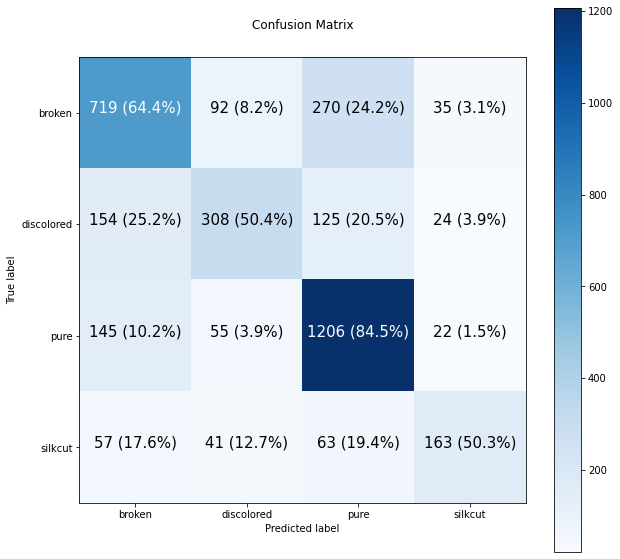

In [ ]:
#Confusion Matrix untuk Model menggunakan data validasi
import matplotlib.pyplot as plt

make_confusion_matrix(y_true=val_label,
                      y_pred=pred_val,
                      classes=validation_generator.class_indices,
                      figsize=(10,10),
                      text_size=15)